# 1 Problem Description

**Just for fun:**

Say you want to introduce a kink into the bedroom as a surprise, but you don't know if your partner will be into it. How effectively can you use their other kink preferences to predict whether they'll be down?

This code trains a very simple decision-tree machine learning classifier for each kink. The goal is to predict whether the preference for the kink is 'yes' (considered "Moderately" or "Extermely" erotic) or 'no' (considered "Not" or "Slightly" erotic).

This data comes from an Aella survey, so to avoid statistics sampling bias problems, have your partner go fill out some of her surveys so that they're in the relevant population.

**Disclaimer:** 

Don't cover your partner in caterpillars because a chart told you to

# 2 Imports

In [1]:
import numpy as np
import pandas as pd
from typing import List
import time
import re
import pickle

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, make_scorer
from sklearn.feature_selection import RFE
from sklearn import tree as tree

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt

# 3 Read Data

In [2]:
data_location = ''
df_data = pd.read_csv(data_location, low_memory=False)

In [3]:
df_data.shape

(10363, 45)

# 4 Preprocess Data

## 4.1 Drop rows with missing data

In [4]:
df_data.dropna(axis=0, how='any', inplace=True)

In [5]:
df_data.shape

(9308, 45)

## 4.2 Transform columns

### 4.2.1 Kink columns

In [6]:
# Encode the kink columns as ordinal numbers
df_data.replace("Not erotic", 0, inplace=True)
df_data.replace("Slightly erotic", 1, inplace=True)
df_data.replace("Moderately erotic", 2, inplace=True)
df_data.replace("Extremely erotic", 3, inplace=True)

### 4.2.2 Gender

In [7]:
# Create one-hot encoding for categorical gender feature
df_gender = pd.get_dummies(data=df_data['Your gender?'], columns=['Your gender?'], drop_first=True, prefix='gender')
df_data = pd.concat(objs=[df_data, df_gender], axis=1)
df_data.drop(columns=['Your gender?'], inplace=True)

### 4.2.3 Age

In [8]:
# Convert the age range into a number
age_map = {
    '<18': 17.0,
    '18-22': 20.0,
    '23-28': 25.5,
    '29-35': 32.0,
    '36-40': 38.0,
    '41-50': 45.5,
    '51-60': 55.5,
    '61-70': 65.5,
    '71+': 71.0
}
df_data['How old are you?'] = df_data.apply(lambda row: age_map[row['How old are you?']], axis=1)

### 4.2.4 Political compass

In [9]:
# Create columns for the left/center/right dimension
df_data['politics_left'] = df_data.apply(lambda row: 'left' in row['Politically, you tend to be more'], axis=1)
df_data['politics_right'] = df_data.apply(lambda row: 'right' in row['Politically, you tend to be more'], axis=1)

# Create columns for the lib/center/auth dimension
df_data['politics_lib'] = df_data.apply(lambda row: 'libertarian' in row['Politically, you tend to be more'], axis=1)
df_data['politics_auth'] = df_data.apply(lambda row: 'authoritarian' in row['Politically, you tend to be more'], axis=1)

df_data.drop(columns=['Politically, you tend to be more'], inplace=True)

### 4.2.5 Sexual orientation

In [10]:
# Create one-hot encoding for categorical sexual orientation feature
df_orientation = pd.get_dummies(data=df_data['Which best describes your sexual orientation?'],
                                columns=['Which best describes your sexual orientation?'],
                                drop_first=True,
                                prefix='orientation')
df_data = pd.concat(objs=[df_data, df_orientation], axis=1)
df_data.drop(columns=['Which best describes your sexual orientation?'], inplace=True)

## 4.3 Rename the columns

In [11]:
kink_columns = [
    'You find "light bondage" to be',
    'You find "alternate sex positions besides missionary" to be',
    'You find "group sex" to be',
    'You find "males dominating" to be',
    'You find "exhibitionism" to be',
    'You find "voyeurism" to be',
    'You find "latex" to be',
    'You find "masochism" to be',
    'You find "asphyxiation/choking" to be',
    'You find "humiliation" to be',
    'You find "necrophilia" to be',
    'You find "lactation" to be',
    'You find "ageplay" to be',
    'You find "anal sex" to be',
    'You find "sadism" to be',
    'You find "female domination" to be',
    'You find "pegging" to be',
    'You find "heavy bondage" to be',
    'You find "inanimate objects" to be',
    'You find "males submitting" to be',
    'You find "sounding" to be',
    'You find "uniforms" to be',
    'You find "raceplay" to be',
    'You find "futa" to be',
    'You find "feet" to be',
    'You find "rapeplay" to be',
    'You find "spanking" to be',
    'You find "24/7 power dynamics" to be',
    'You find "scat" to be',
    'You find "Monsters/aliens/tentacles/deformations" to be',
    'You find "Animal roleplay or petplay" to be',
    'You find "dirtiness" to be',
    'You find "incest" to be',
    'You find "piercing/cutting" to be',
    'You find "pedophilia" to be',
    'You find "vore" to be',
    'You find "female use of sex toys" to be',
    'You find "creepy crawlies" to be',
    'You find "male use of sex toys" to be',
    'You find "bestiality" to be',
    'You find "females submitting" to be'
]

def transform_column_name(column_name: str) -> str:
    new_column_name = column_name
    
    kink_match = re.match('You find "(.*)" to be', column_name)
    if kink_match is not None:
        new_column_name = kink_match.group(1)
    
    # Lowercase, replace spaces with underscores, remove most punctuation
    return re.sub('[^a-z0-9_/]', '', new_column_name.lower().replace(' ', '_'))

# Rename the columns
df_data.columns = [transform_column_name(column_name) for column_name in df_data.columns]

In [12]:
pd.set_option('display.max_columns', 100)
df_data

,light_bondage,alternate_sex_positions_besides_missionary,group_sex,males_dominating,exhibitionism,voyeurism,latex,masochism,asphyxiation/choking,humiliation,necrophilia,lactation,ageplay,anal_sex,sadism,female_domination,pegging,heavy_bondage,inanimate_objects,males_submitting,sounding,uniforms,raceplay,futa,feet,rapeplay,spanking,24/7_power_dynamics,scat,monsters/aliens/tentacles/deformations,animal_roleplay_or_petplay,dirtiness,incest,piercing/cutting,pedophilia,vore,female_use_of_sex_toys,creepy_crawlies,male_use_of_sex_toys,bestiality,females_submitting,how_old_are_you,gender_female_trans,gender_male_cis,gender_male_trans,gender_nonbinary_afab,gender_nonbinary_amab,gender_other_amab,gender_choice_8,politics_left,politics_right,politics_lib,politics_auth,orientation_bisexual_equally_attracted_to_both_genders,orientation_bisexual_leaning_gay,orientation_bisexual_leaning_straight,orientation_gay_cis_and_trans_attracted,orientation_gay_super_gay_cis_attracted,orientation_pansexual,orientation_straight_cis_and_trans_attracted,orientation_straight_super_straight_cisattracted
0,3,1,1,2,2,2,2,2,0,1,0,0,0,1,1,1,1,1,0,2,0,0,0,2,0,3,1,3,0,0,0,0,0,0,3,0,2,0,2,0,1,17.0,1,0,0,0,0,0,0,True,False,True,False,0,0,0,0,0,0,1,0
2,3,3,3,3,3,3,3,3,3,3,0,3,0,0,3,3,3,3,1,3,3,3,0,3,0,3,2,3,0,3,3,0,0,3,0,1,3,0,3,0,3,17.0,0,0,0,1,0,0,0,True,False,True,False,0,0,0,0,0,1,0,0
3,3,3,3,1,0,0,3,3,3,2,0,0,0,0,3,3,3,0,1,3,0,3,0,3,0,0,3,3,0,3,3,0,0,3,0,0,2,0,2,0,0,17.0,0,0,0,0,0,0,0,True,False,False,True,1,0,0,0,0,0,0,0
4,3,3,1,3,1,1,0,1,1,0,0,0,0,2,2,0,0,0,0,0,0,2,0,2,1,1,3,0,0,0,0,0,1,0,1,0,2,0,0,0,1,17.0,0,1,0,0,0,0,0,False,False,False,False,0,0,0,0,0,0,1,0
5,3,3,3,3,3,3,3,3,3,3,3,1,3,3,3,3,3,3,1,3,0,2,0,3,3,3,3,3,3,1,3,3,3,3,3,3,3,0,2,3,3,17.0,0,1,0,0,0,0,0,False,False,False,False,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10261,1,3,3,0,2,2,3,1,1,0,1,2,3,3,1,2,3,2,1,3,0,2,2,3,1,0,2,2,2,0,3,0,3,3,3,0,3,1,3,3,3,65.5,0,1,0,0,0,0,0,True,False,True,False,0,0,0,0,0,0,1,0
10262,1,2,1,2,1,2,0,2,0,0,0,1,0,2,1,2,1,1,1,1,3,1,0,1,1,1,3,1,0,1,1,1,0,2,0,0,3,1,2,3,2,65.5,0,1,0,0,0,0,0,False,True,False,True,0,0,0,0,0,0,0,1
10264,1,3,1,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,0,2,0,0,0,2,71.0,0,1,0,0,0,0,0,True,False,True,False,0,0,0,0,0,0,0,1
10266,1,2,1,2,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,2,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,71.0,0,1,0,0,0,0,0,False,False,False,False,0,0,0,0,0,0,0,1


# 5 Supervised Machine Learning

## 5.1 Define the ML pipeline functions

In [13]:
df = df_data
def train_eval_model(training_columns: List[str], target_column: str, tree_max_depth: int) -> List[List[float]]:
    # Specify hyperparameter selection metric
    hyperparameter_selection = make_scorer(balanced_accuracy_score)

    # Grid of parameters for RandomizedSearchCV
    random_params = {
        'algorithm__criterion': ['entropy'],
        'algorithm__min_samples_split': range(1, 10),
        'algorithm__min_samples_leaf': range(1, 5)
    }

    # Build model pipeline
    model_pipeline = Pipeline(steps=[
        ('algorithm', DecisionTreeClassifier(random_state=random_seed, max_features=tree_max_depth))
    ])
    
    # Use prediction kink preference >= 2 as the target
    target_column_vector = df[target_column] >= 2
    
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(df[training_columns],
                                                        target_column_vector,
                                                        test_size=0.25,
                                                        random_state=random_seed)
    # Find best hyperparameters
    random_search_cv = RandomizedSearchCV(
        estimator=model_pipeline,
        param_distributions=random_params,
        cv=5,
        scoring=hyperparameter_selection,
        n_iter=200,
        random_state=random_seed,
        verbose=1,
        n_jobs=-1
    )

    # Fit training data
    time_start = time.perf_counter()
    random_search_cv.fit(X_train, y_train)
    time_elapsed_seconds = time.perf_counter() - time_start
    print(f'Time for training (seconds): {time_elapsed_seconds}')

    # Get best estimator from cross-validation
    model = random_search_cv.best_estimator_
    
    # Calculate result and return confusion matrix
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    return random_search_cv, conf_mat

## 5.2 Execute for each kink

In [ ]:
results = {}

kink_columns = list(df.columns)[0:41]

# Iterate over each kink
for kink in kink_columns:
    target_column = kink
    training_columns = [column for column in df.columns if column != target_column]
    
    # Train and evaluate model
    cv, conf_mat = train_eval_model(training_columns=training_columns,
                                    target_column=target_column,
                                    tree_max_depth=2)
    
    # Save results
    results[kink] = {}
    results[kink]['tree'] = cv.best_estimator_[0][1]
    c = conf_mat
    results[kink]['acc'] = (c[0][0] + c[1][1]) / (c[0][0] + c[0][1] + c[1][0] + c[1][1])
    results[kink]['fdr'] = 0.0 if (c[0][1] + c[1][1]) == 0 else c[0][1] / (c[0][1] + c[1][1])
    results[kink]['features'] = training_columns

## 5.3 Plot Results

**Interpreting the results**:
- Summary
  - "Predicting" : the kink preference that is being predicted
  - "Accuracy" : the proportion of correct predictions by the tree (test set)
  - "False Discovery Rate" : when the prediction is 'yes', the proportion of incorrect predictions by the tree (test set)
- Decision Trees
  - criterion: if true -> go left, if false -> go right
    - kink features: "Not Erotic"=0, "Slightly Erotic"=1, "Moderately Erotic"=2, "Extremely Erotic"=3
    - yes/no features: yes=1, no=0
  - "samples": the percentage of the samples in this box across horizontally (training set)
  - "value": the proportion of \['no', 'yes'\] in this box for the kink being predicted (training set)
  - "class": if you stopped here, what would you predict?
  - color: more orange = more 'no', more blue = more 'yes'

--------------------------------------------------
Predicting: light_bondage
Accuracy: 0.67
False Discovery Rate: 0.32


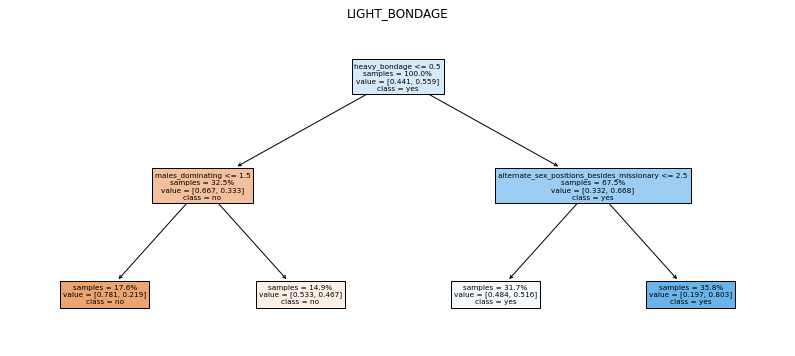

--------------------------------------------------
Predicting: alternate_sex_positions_besides_missionary
Accuracy: 0.85
False Discovery Rate: 0.15


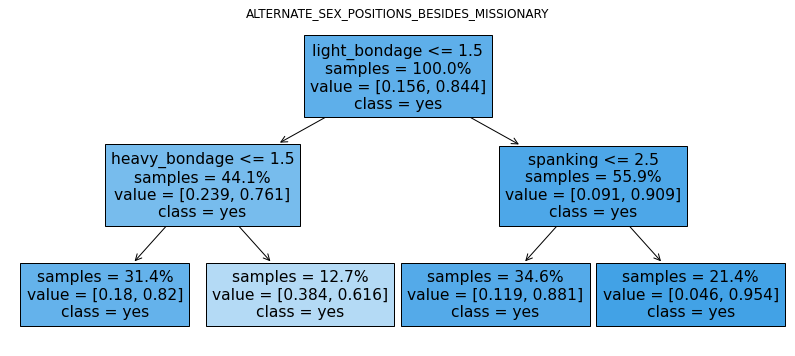

--------------------------------------------------
Predicting: group_sex
Accuracy: 0.68
False Discovery Rate: 0.32


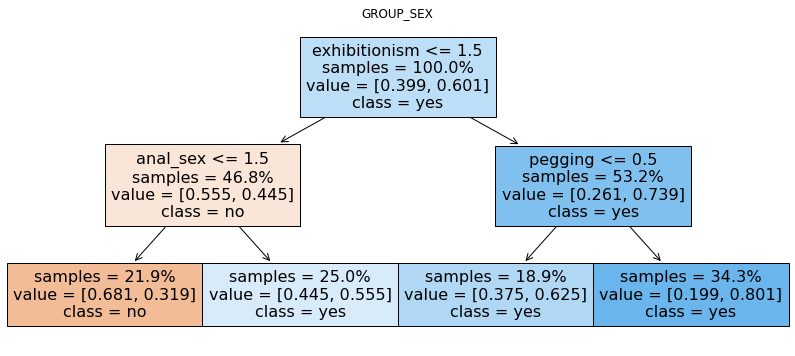

--------------------------------------------------
Predicting: males_dominating
Accuracy: 0.74
False Discovery Rate: 0.25


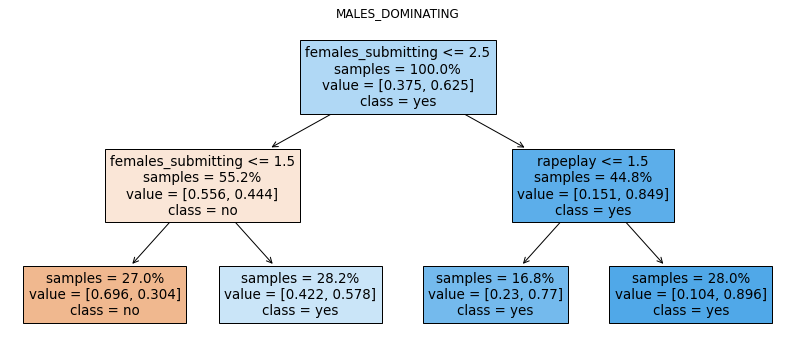

--------------------------------------------------
Predicting: exhibitionism
Accuracy: 0.75
False Discovery Rate: 0.21


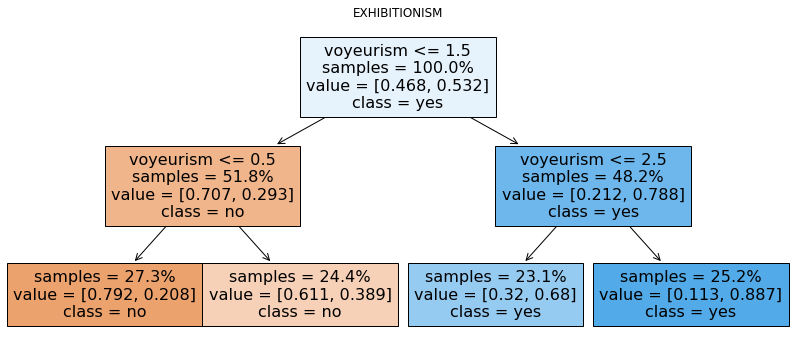

--------------------------------------------------
Predicting: voyeurism
Accuracy: 0.75
False Discovery Rate: 0.28


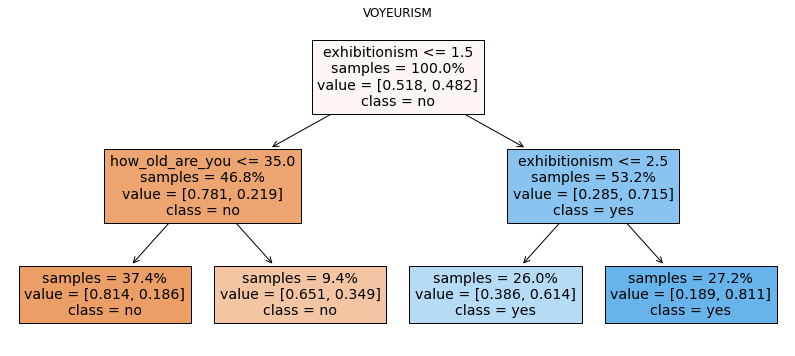

--------------------------------------------------
Predicting: latex
Accuracy: 0.82
False Discovery Rate: 0.47


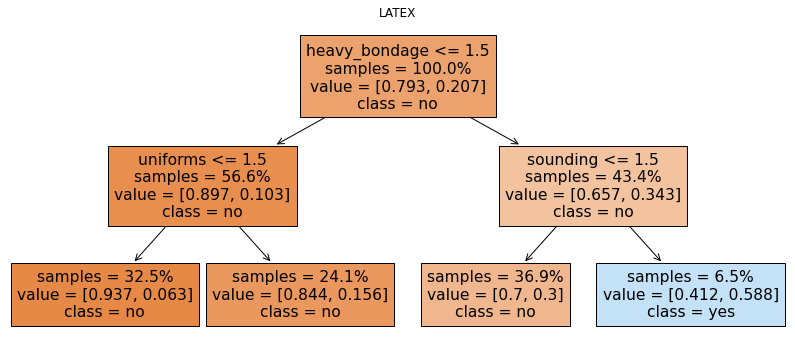

--------------------------------------------------
Predicting: masochism
Accuracy: 0.8
False Discovery Rate: 0.28


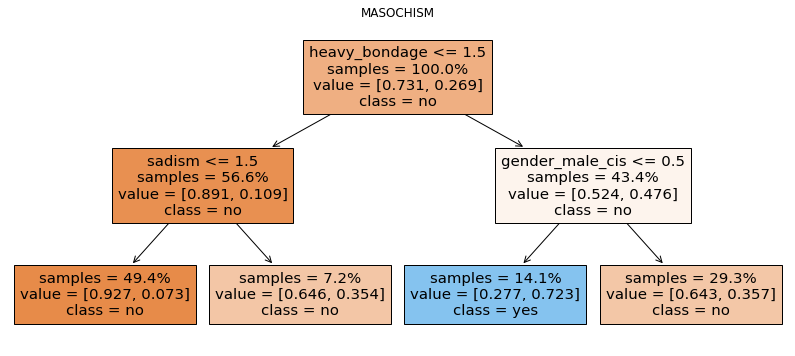

--------------------------------------------------
Predicting: asphyxiation/choking
Accuracy: 0.76
False Discovery Rate: 0.35


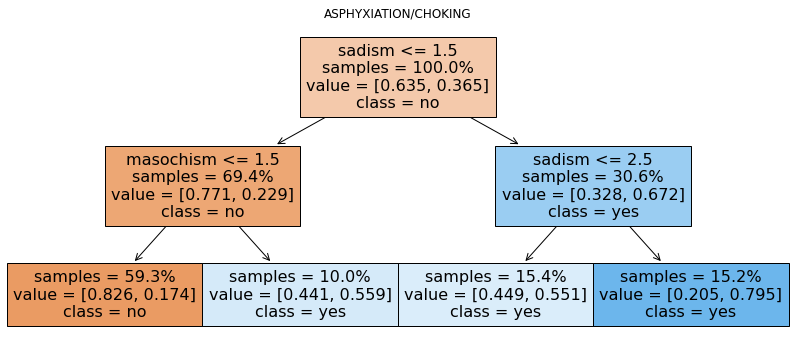

--------------------------------------------------
Predicting: humiliation
Accuracy: 0.76
False Discovery Rate: 0.23


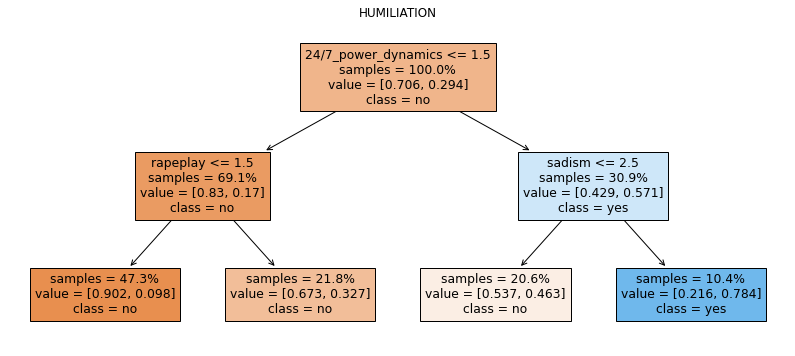

--------------------------------------------------
Predicting: necrophilia
Accuracy: 0.97
False Discovery Rate: 0.42


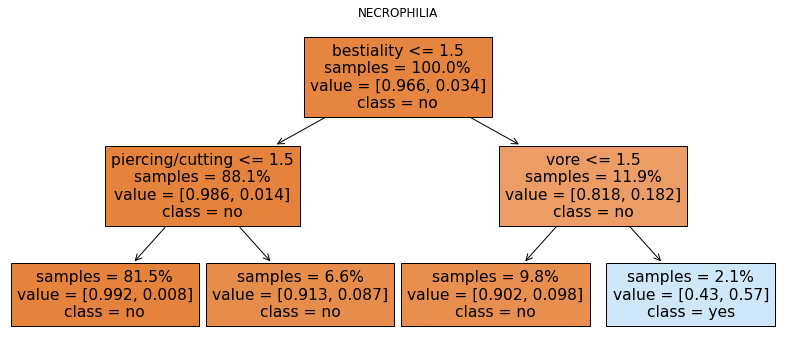

--------------------------------------------------
Predicting: lactation
Accuracy: 0.79
False Discovery Rate: 0.42


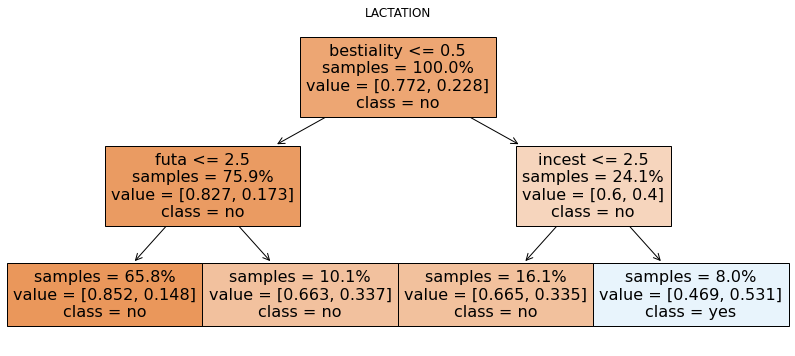

--------------------------------------------------
Predicting: ageplay
Accuracy: 0.84
False Discovery Rate: 0.29


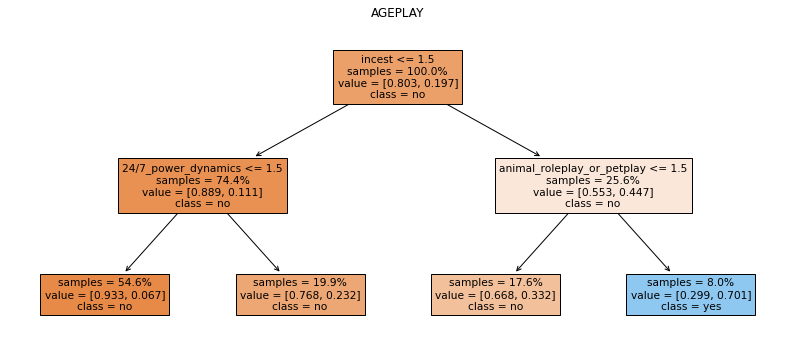

--------------------------------------------------
Predicting: anal_sex
Accuracy: 0.68
False Discovery Rate: 0.28


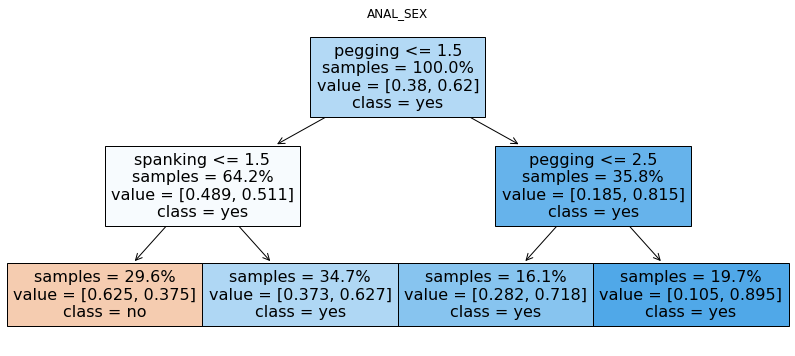

--------------------------------------------------
Predicting: sadism
Accuracy: 0.78
False Discovery Rate: 0.26


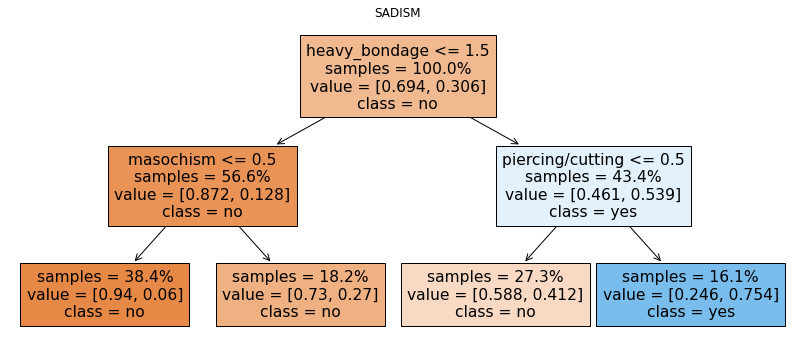

--------------------------------------------------
Predicting: female_domination
Accuracy: 0.77
False Discovery Rate: 0.2


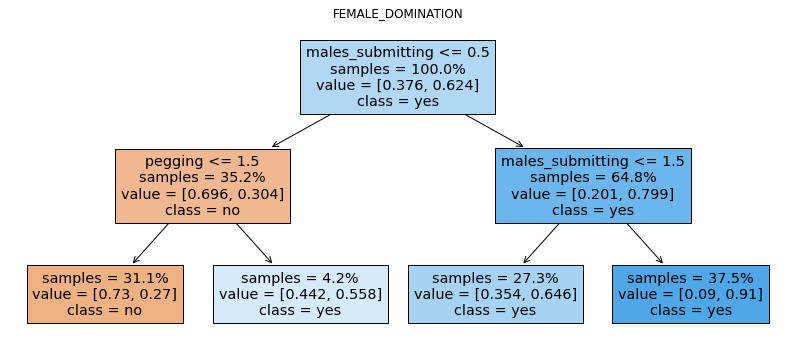

--------------------------------------------------
Predicting: pegging
Accuracy: 0.76
False Discovery Rate: 0.2


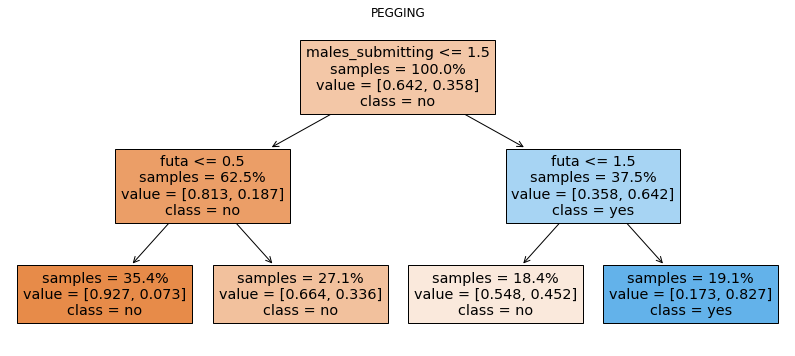

--------------------------------------------------
Predicting: heavy_bondage
Accuracy: 0.73
False Discovery Rate: 0.21


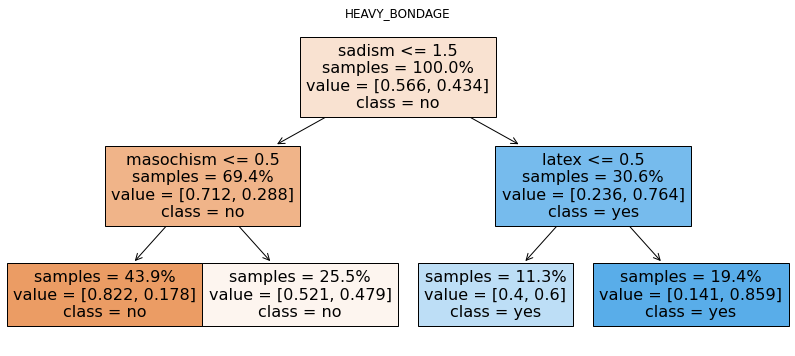

--------------------------------------------------
Predicting: inanimate_objects
Accuracy: 0.91
False Discovery Rate: 0.59


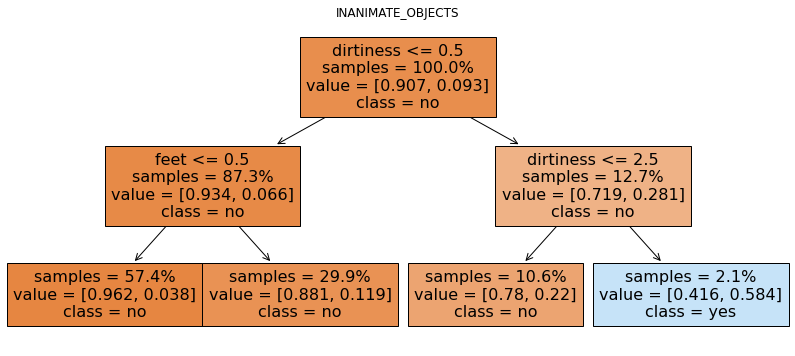

--------------------------------------------------
Predicting: males_submitting
Accuracy: 0.8
False Discovery Rate: 0.27


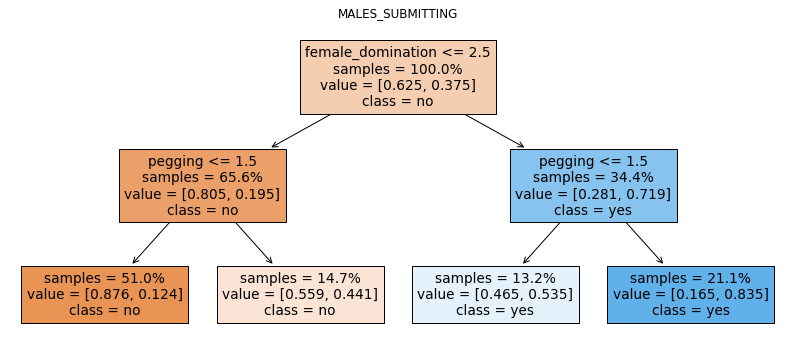

--------------------------------------------------
Predicting: sounding
Accuracy: 0.92
False Discovery Rate: 0.26


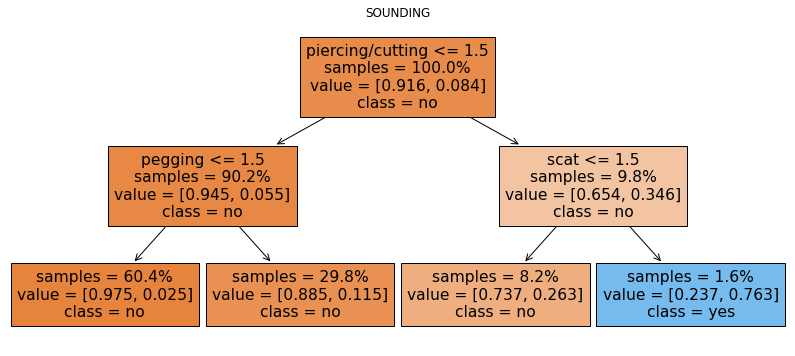

--------------------------------------------------
Predicting: uniforms
Accuracy: 0.6
False Discovery Rate: 0.45


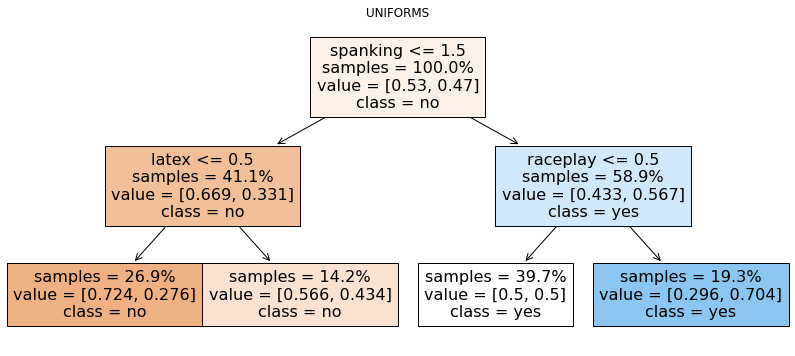

--------------------------------------------------
Predicting: raceplay
Accuracy: 0.86
False Discovery Rate: 0.0


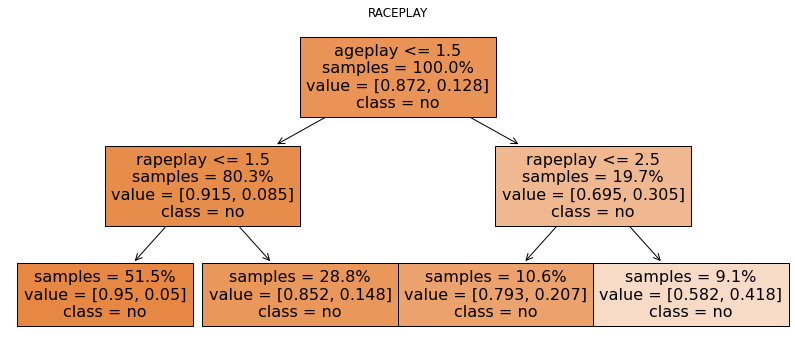

--------------------------------------------------
Predicting: futa
Accuracy: 0.77
False Discovery Rate: 0.33


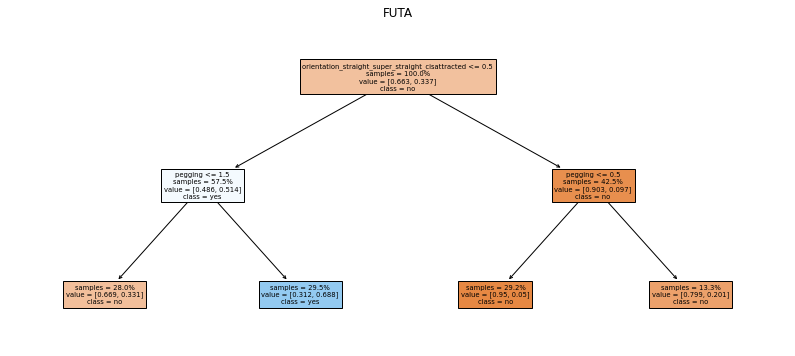

--------------------------------------------------
Predicting: feet
Accuracy: 0.86
False Discovery Rate: 0.0


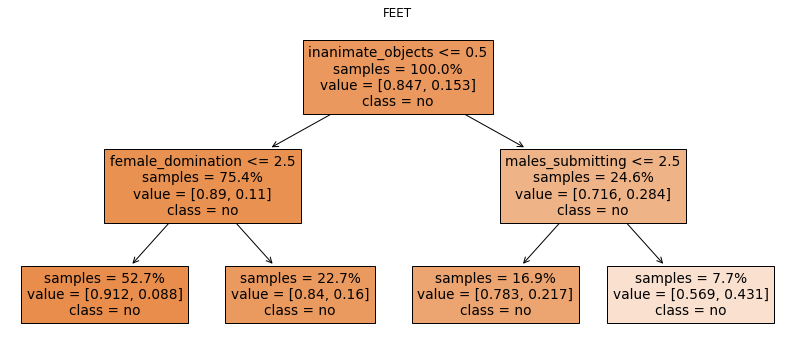

--------------------------------------------------
Predicting: rapeplay
Accuracy: 0.73
False Discovery Rate: 0.34


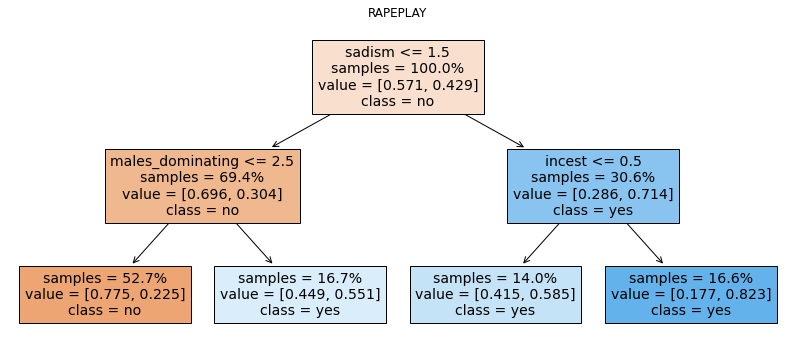

--------------------------------------------------
Predicting: spanking
Accuracy: 0.72
False Discovery Rate: 0.28


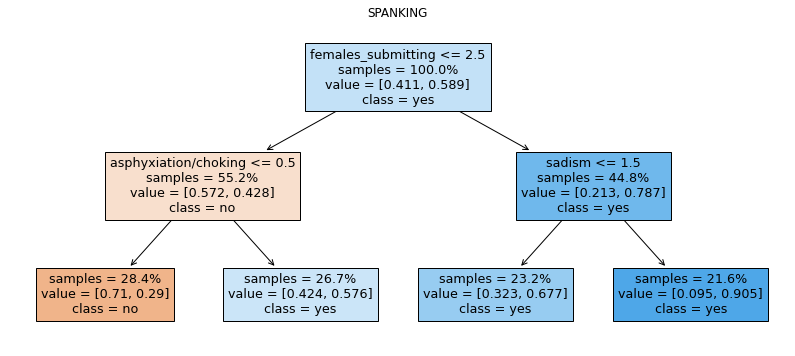

--------------------------------------------------
Predicting: 24/7_power_dynamics
Accuracy: 0.76
False Discovery Rate: 0.3


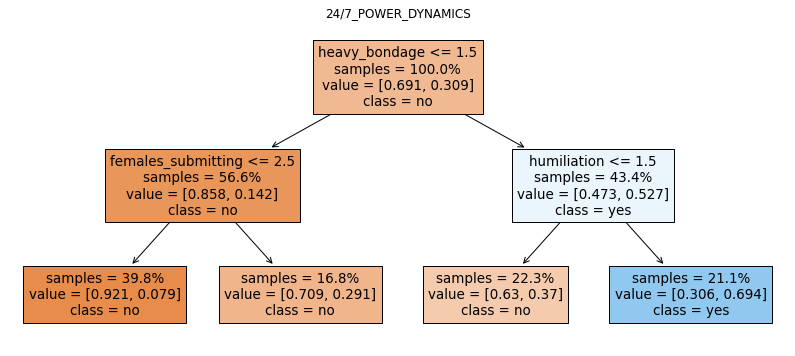

--------------------------------------------------
Predicting: scat
Accuracy: 0.97
False Discovery Rate: 0.24


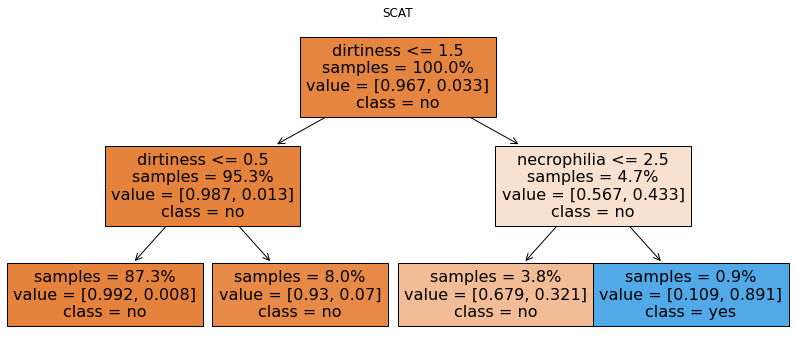

--------------------------------------------------
Predicting: monsters/aliens/tentacles/deformations
Accuracy: 0.83
False Discovery Rate: 0.26


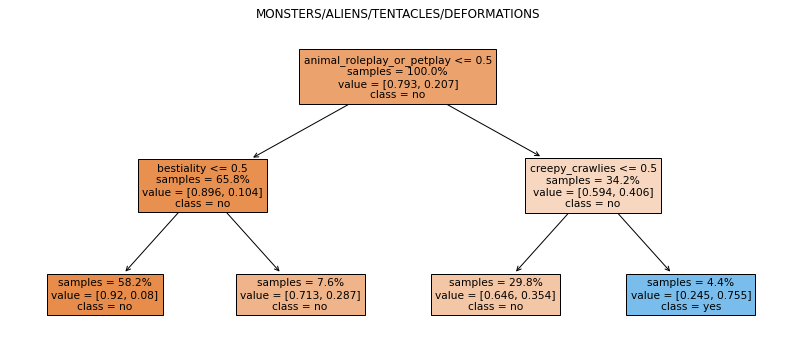

--------------------------------------------------
Predicting: animal_roleplay_or_petplay
Accuracy: 0.86
False Discovery Rate: 0.42


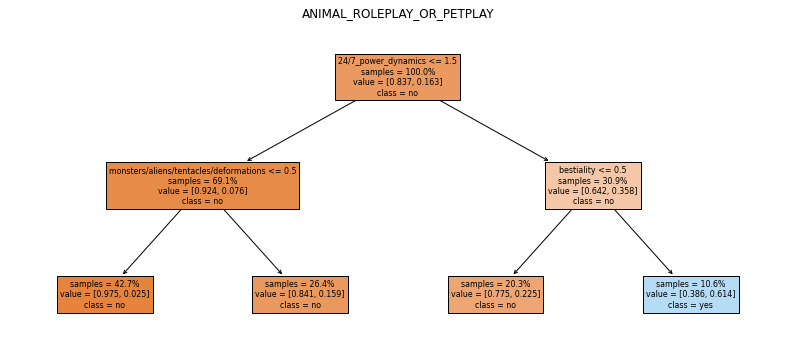

--------------------------------------------------
Predicting: dirtiness
Accuracy: 0.95
False Discovery Rate: 0.5


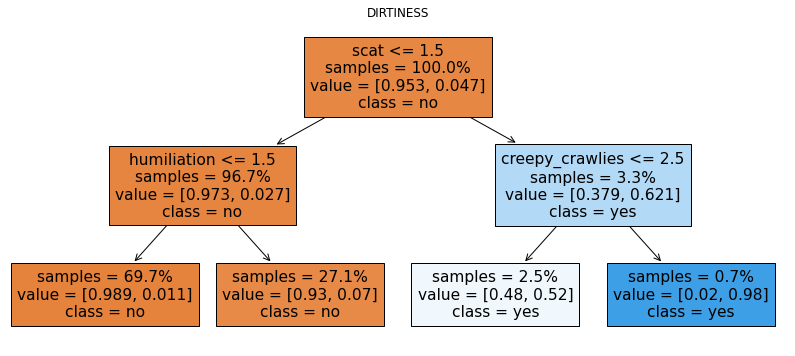

--------------------------------------------------
Predicting: incest
Accuracy: 0.79
False Discovery Rate: 0.19


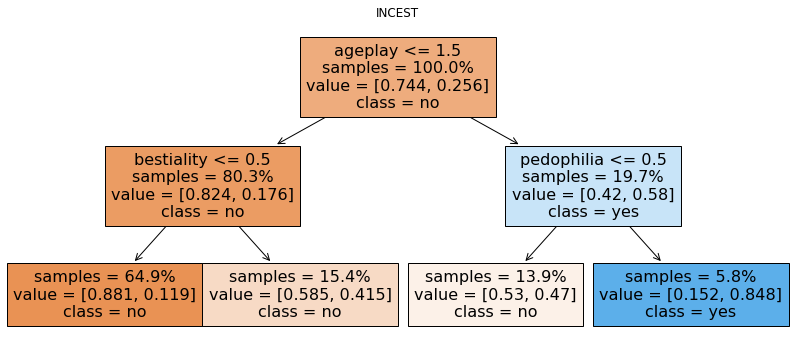

--------------------------------------------------
Predicting: piercing/cutting
Accuracy: 0.9
False Discovery Rate: 0.0


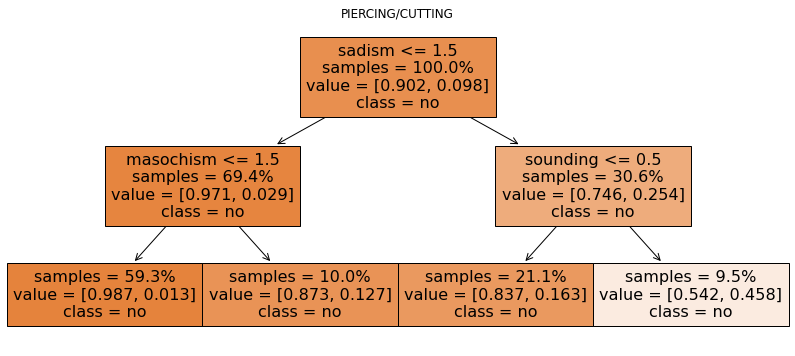

--------------------------------------------------
Predicting: pedophilia
Accuracy: 0.94
False Discovery Rate: 0.42


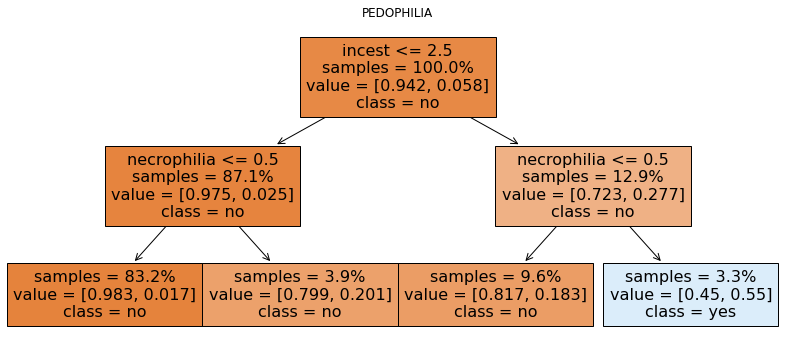

--------------------------------------------------
Predicting: vore
Accuracy: 0.96
False Discovery Rate: 0.3


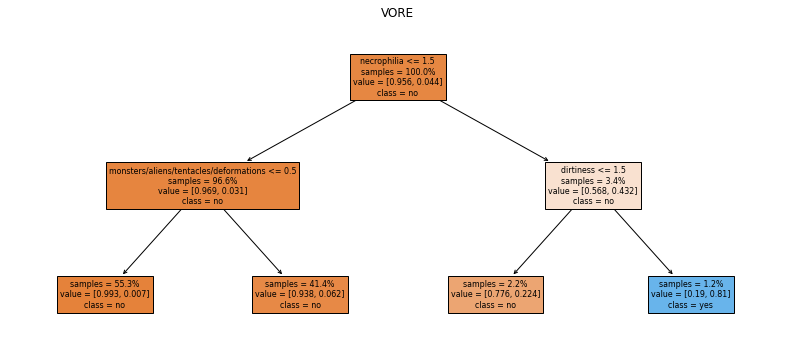

--------------------------------------------------
Predicting: female_use_of_sex_toys
Accuracy: 0.78
False Discovery Rate: 0.19


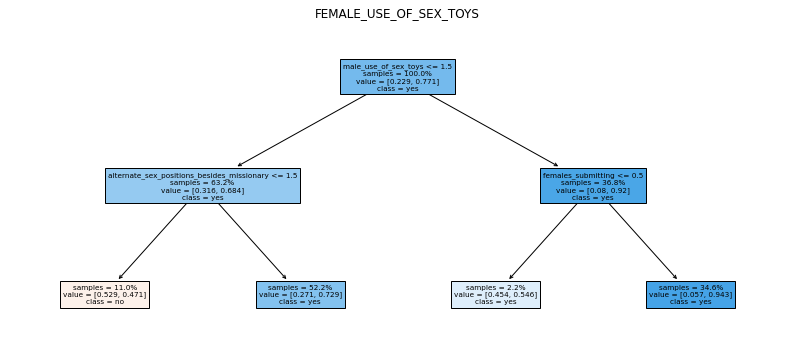

--------------------------------------------------
Predicting: creepy_crawlies
Accuracy: 0.98
False Discovery Rate: 0.26


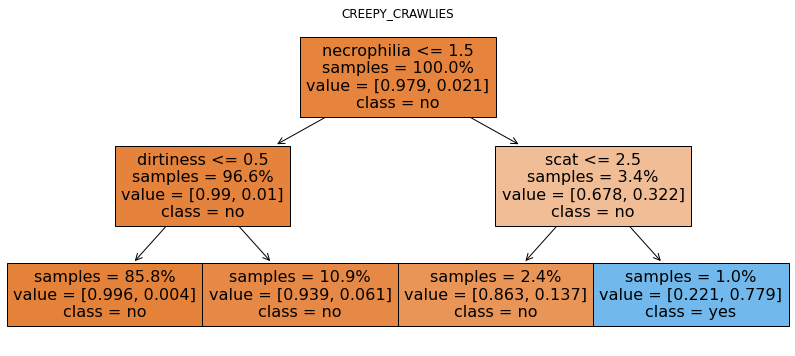

--------------------------------------------------
Predicting: male_use_of_sex_toys
Accuracy: 0.76
False Discovery Rate: 0.31


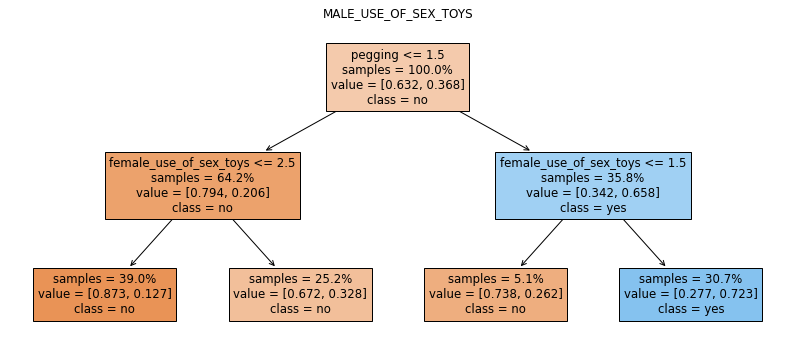

--------------------------------------------------
Predicting: bestiality
Accuracy: 0.9
False Discovery Rate: 0.39


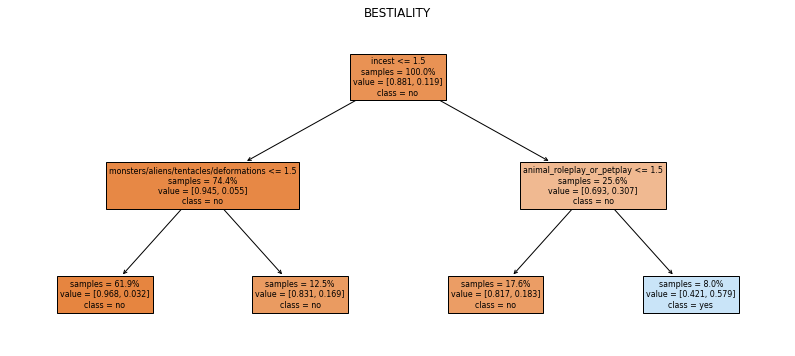

--------------------------------------------------
Predicting: females_submitting
Accuracy: 0.79
False Discovery Rate: 0.17


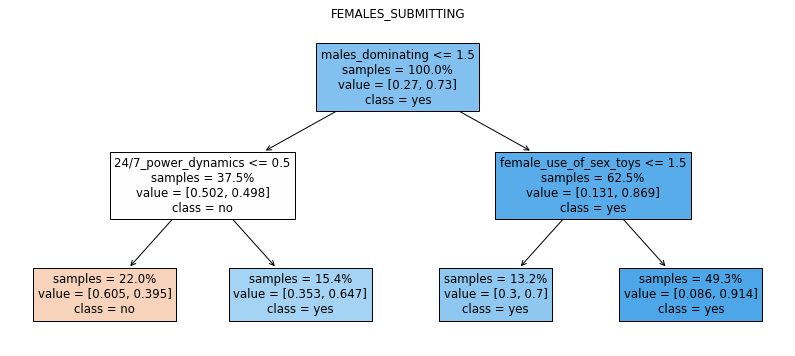

In [15]:
tree_plots = {}
for kink in results.keys():
    tree_plots[kink] = plt.figure(figsize=(14,6))
    tree.plot_tree(
        decision_tree=results[kink]['tree'],
        class_names=['no', 'yes'],
        feature_names=results[kink]['features'],
        impurity=False,
        filled=True,
        proportion=True)
    plt.title(kink.upper())
    print('--------------------------------------------------')
    print(f'Predicting: {kink}')
    print(f'Accuracy: {round(results[kink]["acc"], 2)}')
    print(f'False Discovery Rate: {round(results[kink]["fdr"], 2)}')
    plt.show()